# Molecule-field interaction potential

The molecule-field interaction Hamiltonian can be constructed as a sum of products of interaction tensors (dipole, moment, polarizability, hyperpolarizability, quadrupole moment, etc.) with external electric and/or magnetic field. The interaction tensors can be computed using the basis of molecular rotational states, see "Rotational dynamics Quickstart" and  "Rotational solutions and matrix elements", or using the molecular vibrational or ro-vibrational solutions obtained in other programs, such as, for example, [TROVE](https://github.com/Trovemaster/TROVE).

We start from computing the rotational solutions and matrix elements for water molecule

In [1]:
from richmol.rot import Molecule, solve, LabTensor
import numpy as np

water = Molecule()

water.XYZ = ("bohr",
             "O",  0.00000000,   0.00000000,   0.12395915,
             "H",  0.00000000,  -1.43102686,  -0.98366080,
             "H",  0.00000000,   1.43102686,  -0.98366080)

# molecular-frame dipole moment (au)
water.dip = [0, 0, -0.7288]

# molecular-frame polarizability tensor (au)
water.pol = [[9.1369, 0, 0], [0, 9.8701, 0], [0, 0, 9.4486]]

water.frame="ipas"

Jmax = 10
water.sym = "C2v"

sol = solve(water, Jmax=Jmax)

# laboratory-frame dipole moment operator
dip = LabTensor(water.dip, sol)

# laboratory-frame polarizability tensor
pol = LabTensor(water.pol, sol)

# field-free Hamiltonian
h0 = LabTensor(water, sol)

In the dipole approximation, the interaction of a molecule with field $E(t)$ can be described by a Hamiltonian $H(t) = H_0 -\sum_{a=x,y,z}\mu_a E_a(t) -\frac{1}{2}\sum_{a,b=x,y,z}\alpha_{a,b} E_a(t)E_b(t) - ...$, where $H_0$ is the molecular field-free Hamiltonian and $\mu_a$ and $\alpha_{a,b}$ denote laboratory-frame dipole moment and polarizability, respectively. Here is an example how we can do it for water molecule `dip`, `pol` and `h0` tensors computed above

In [2]:
from richmol.convert_units import AUdip_x_Vm_to_invcm, AUpol_x_Vm_to_invcm

# X, Y, Z components of field
field = [1000, 0, 5000] # field in units of V/m

fac1 = AUdip_x_Vm_to_invcm() # converts dipole(au) * field(V/m) into energy(cm^-1)
fac2 = AUdip_x_Vm_to_invcm() # converts polarizability(au) * field(V/m)**2 into energy(cm^-1)

# field-interaction Hamiltonian
Hp = -fac1 * dip * field - 1/2 * fac2 * pol * field

# total Hamiltonian
H = h0 + Hp

The product of a tensor with field each time generates a new tensor object, which sometimes, when the field is updated too often, can be inefficient. Instead, one can multiply tensor with field in-place

In [3]:
fac1 = AUdip_x_Vm_to_invcm() # converts dipole(au) * field(V/m) into energy(cm^-1)
fac2 = AUdip_x_Vm_to_invcm() # converts polarizability(au) * field(V/m)**2 into energy(cm^-1)

Hdip = -fac1 * dip
Hpol = - 1/2 * fac2 * pol

for fz in np.linspace(0, 100000, 10):
    field = [1000, 0, fz]
    Hdip.field(field)
    Hpol.field(field)
    H = h0 + Hdip + Hpol

Hamiltonian has almost all properties of a tensor object. For example, one can use `tomat` method to obtain its matrix elements. Here is how we can use `tomat` to compute Stark energies for different field strengths by diagonalizing the matrix representation of Hamiltonian

In [4]:
fac1 = AUdip_x_Vm_to_invcm() # converts dipole(au) * field(V/m) into energy(cm^-1)

Hdip = -fac1 * dip

enr = []

for fz in np.linspace(0, 100000, 10):
    print(f"run Fz = {fz}")
    field = [0, 0, fz]
    Hdip.field(field)
    H = h0 + Hdip
    e, v = np.linalg.eigh(H.tomat(form="full", repres="dense"))
    enr.append(e)

run Fz = 0.0
run Fz = 11111.111111111111
run Fz = 22222.222222222223
run Fz = 33333.333333333336
run Fz = 44444.444444444445
run Fz = 55555.555555555555
run Fz = 66666.66666666667
run Fz = 77777.77777777778
run Fz = 88888.88888888889
run Fz = 100000.0


Plot Stark energies and assignment for a selected state

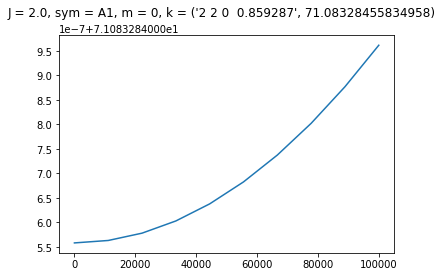

In [9]:
import matplotlib.pyplot as plt

enr = np.array(enr)
assign, _ = h0.assign(form="full")

# print Stark curve and assignment for selected state index

state_index = 14
state_assign = f"J = {assign['J'][state_index]}, " + \
               f"sym = {assign['sym'][state_index]}, " + \
               f"m = {assign['m'][state_index]}, " + \
               f"k = {assign['k'][state_index]}"

plt.plot(np.linspace(0, 100000, 10), enr[:, state_index])
plt.suptitle(state_assign)
plt.show()